In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf


In [30]:
df = yf.Ticker('NQ=F')
df = df.history(start='2010-01-01', end='2024-01-01')

### Calcular medias móviles


In [31]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

### Definir reglas de entrada y salida


In [32]:
#Ejemplo original
df['Signal'] = 0
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1 # Compra
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1 # venta

In [33]:
# # Ejemplo 2 si la posicion esta abierta. 
# df['Signal'] = 0
# position_open = False

# for i in range(1, len(df)):
#     # Señal de compra: SMA_50 cruza por encima de SMA_200 y no hay posición abierta
#     if df.iloc[i]['SMA_50'] > df.iloc[i]['SMA_200'] and not position_open:
#         df.loc[df.index[i], 'Signal'] = 1  # Señal de compra
#         position_open = True
    
#     # Señal de venta: SMA_50 cruza por debajo de SMA_200 y hay una posición abierta
#     elif df.iloc[i]['SMA_50'] < df.iloc[i]['SMA_200'] and position_open:
#         df.loc[df.index[i], 'Signal'] = -1  # Señal de venta
#         position_open = False       

In [34]:
# Ejemplo 3 para evitar bucles, hace lo mismo que el ejemplo 2

# df['Position'] = (df['SMA_50'] > df['SMA_200']).astype(int)  # 1 si SMA_50 > SMA_200, 0 en caso contrario
# df['Signal'] = df['Position'].diff()  # Detectar cambios en la posición
# df['Signal'] = df['Signal'].fillna(0).astype(int)  # Reemplazar NaN inicial por 0 y convertir a int

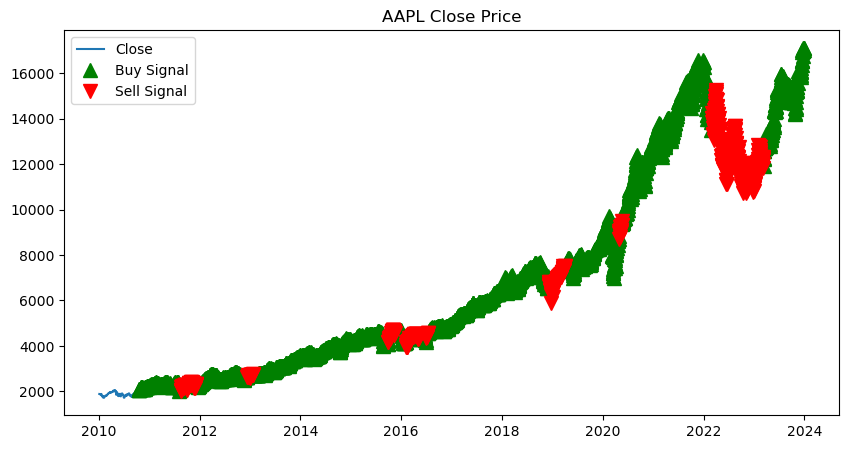

In [35]:
# graficar en un grafico de precios los puntos de compra y venta

plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close')
plt.plot(df.loc[df['Signal'] == 1, 'Close'], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df.loc[df['Signal'] == -1, 'Close'], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('AAPL Close Price')
plt.legend()
plt.show()


### Simular la ejecución de las órdenes

In [36]:
df['Position'] = df['Signal'].shift()  # Shift para simular la ejecución al siguiente día

In [37]:
# Para simular las posiciones del emplo 2 y 3
#df['Position'] = df['Signal'].cumsum()  # Acumula las posiciones (1 para long, 0 para neutral)

### Definir comisiones y slippage

In [38]:

commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación

### Calcular los retornos de la estrategia con comisiones y slippage

In [39]:
df['Returns'] = df['Close'].pct_change() #Retorno diarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']


In [40]:
# Para calcular los retornos del ejempl 2 y 3
df['Strategy_Returns'] = df['Position'].shift() * df['Returns']  # Retornos de la estrategia


### Aplicar comisiones y slippage
Nota: Ajusta los valores de comisiones y slippage según el broker.

In [41]:
df['Strategy_Returns'] -= (abs(df['Position'].diff()) * (commission + slippage))

In [42]:
# Eliminar NaNs
df.dropna(inplace=True)

### Calcular rendimiento total y anualizado

In [43]:
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1 # Ajustado por 252 días de trading anuales

print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 222.32%
Rendimiento Anualizado: 9.28%


### Ratio de Sharpe

In [44]:
risk_free_rate = 0.01  # Supongamos que la tasa libre de riesgo es del 1%
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)  # Retornos en exceso sobre la tasa libre de riesgo
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Ratio de Sharpe: 0.03


### Drawdown Máximo

In [45]:
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -40.55%


### Ratio de Ganancias/Pérdidas

In [46]:
winning_trades = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].count()
lossing_trades = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].count()

win_lose_ratio = winning_trades / lossing_trades if lossing_trades != 0 else np.inf

ganancia_media = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
perdida_media = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].mean()

print(f'Operaciones Ganadoras: {winning_trades} -- Ganancia Media: {ganancia_media:.2%}')
print(f'Operaciones Perdedoras: {lossing_trades} -- Ganancia Media: {perdida_media:.2%}')
print(f'Ratio Ganancias/Pérdidas: {win_lose_ratio:.2f}')

Operaciones Ganadoras: 1830 -- Ganancia Media: 0.86%
Operaciones Perdedoras: 1492 -- Ganancia Media: -0.95%
Ratio Ganancias/Pérdidas: 1.23


### Graficar el rendimiento de la estrategia frente al activo


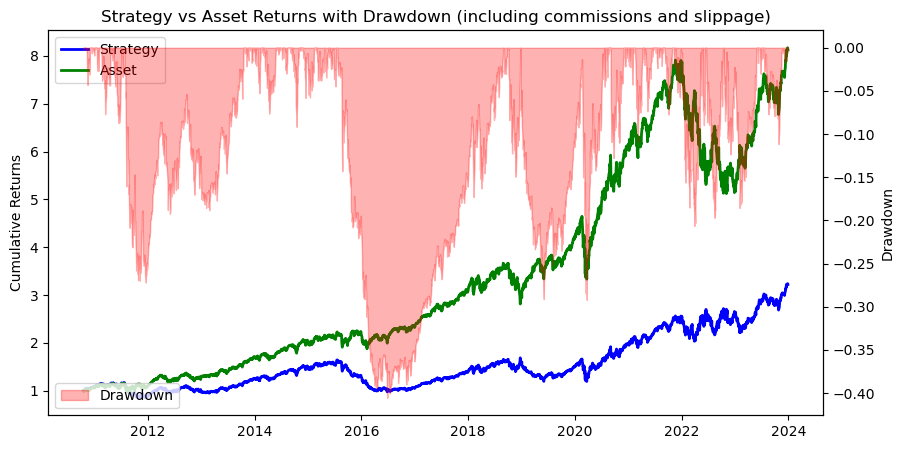

In [47]:

fig, ax1 = plt.subplots(figsize=(10, 5))

# Graficar los rendimientos acumulados de la estrategia
ax1.plot(df.index, df['Cumulative_Returns'], label='Strategy', color='blue', lw=2)

# Graficar los rendimientos acumulados del activo directamente usando Close
ax1.plot(df.index, (df['Close'] / df['Close'].iloc[0]), label='Asset', color='green', lw=2)

ax1.set_ylabel('Cumulative Returns')

# Graficar el drawdown coloreado
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Drawdown'], 0, color='red', alpha=0.3, label='Drawdown')
ax2.set_ylabel('Drawdown')

# Configurar leyendas y títulos
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commissions and slippage)')
plt.show()